In [2]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import cPickle as pickle
from matplotlib import pyplot as plt
from datetime import datetime
from scipy.optimize import curve_fit
pd.set_option('notebook_repr_html', False)
pd.set_option('display.max_rows', 20)

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 1.25 * matplotlib.rcParams['savefig.dpi']
from collections import OrderedDict
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool

In [3]:
trips_df = pickle.load(open('trips_2014.pickle', 'rb'))
stations_df = pickle.load(open('stations_2014.pickle', 'rb'))
gaptimes_by_month_bikeid = pickle.load(open('gaptimes_by_month_bikeid.pickle', 'rb'))
gaptimes_by_month = pickle.load(open('gaptimes_by_month.pickle', 'rb'))

print len(trips_df), len(stations_df)

2454634 300


In [6]:
def func(t, tau, A):
    return A*np.exp(-t/tau)

taus = []
As = []
for month in range(12):
    gaptimes = gaptimes_by_month[month]
    data = gaptimes[(gaptimes>0.5) & (gaptimes<4.5)]

    hist_data = np.histogram(data, bins=16)
    xs = (hist_data[1][:-1]+hist_data[1][1:])/2
    ys = hist_data[0]
    tau, A = curve_fit(func, xs, ys, p0=[2.0, 1000])[0]
    taus.append(tau)
    As.append(A)
print taus
print As

[2.3854288387544265, 2.6416162519632764, 2.2488762973403627, 1.7707832009569611, 1.4603755432211063, 1.3849312277745953, 1.39647542142324, 1.3704545692066148, 1.4812914146109954, 1.6607987096210481, 2.0118114292385427, 2.1413216927615242]
[926.91845680674191, 906.48791888225878, 3197.231805995229, 10838.264341148346, 25705.199272882746, 35561.849283608746, 42052.103691171345, 40710.838792920826, 29204.803734328645, 19058.920816473139, 6737.1242551813657, 4356.4165241580849]


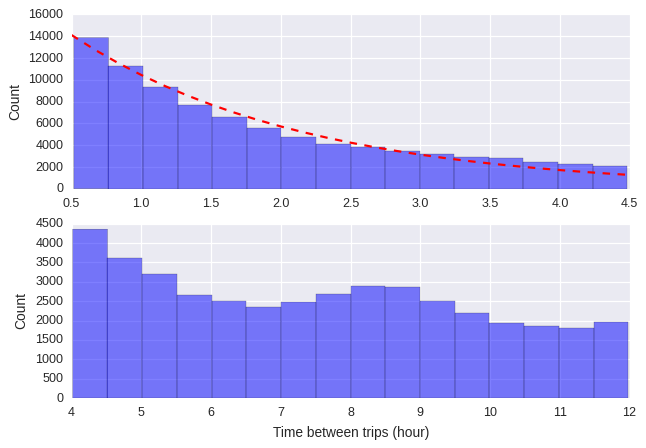

In [10]:
month = 9
gaptimes = gaptimes_by_month[month]
short_data = gaptimes[(gaptimes>0.5) & (gaptimes<4.5)]
long_data = gaptimes[(gaptimes>4) & (gaptimes<12)]

plt.subplot(2,1,1)
plt.hist(short_data, bins=16, alpha=0.5, color='b')
xs0 = np.linspace(0.5, 4.5, 25)
plt.plot(xs0, func(xs0, taus[month], As[month]),'r--')
plt.xlim(0.5, 4.5)
#plt.xlabel('Time between trips (hour)')
plt.ylabel('Count')

plt.subplot(2,1,2)
plt.hist(long_data, bins=16, alpha=0.5, color='b')
plt.xlim(4, 12)
#plt.ylim(3000, 6500)
plt.xlabel('Time between trips (hour)')
plt.ylabel('Count')
plt.show()

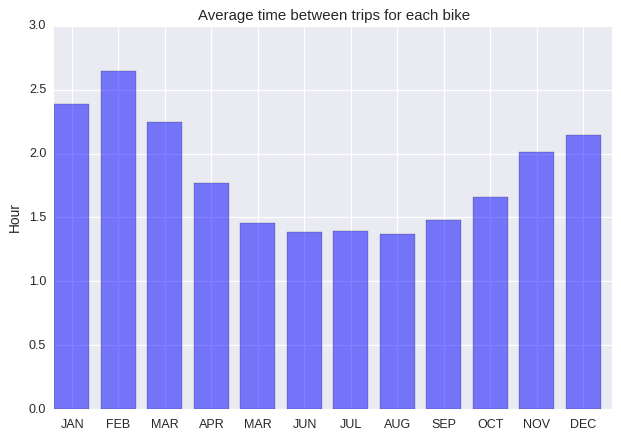

In [11]:
index = np.arange(12)
bar_width = 0.75
plt.bar(index, taus, bar_width, color='b', alpha=0.5)
plt.title('Average time between trips for each bike')
plt.ylabel('Hour')
plt.xticks(index+bar_width/2, ('JAN', 'FEB', 'MAR', 'APR', 'MAR', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'))
plt.show()

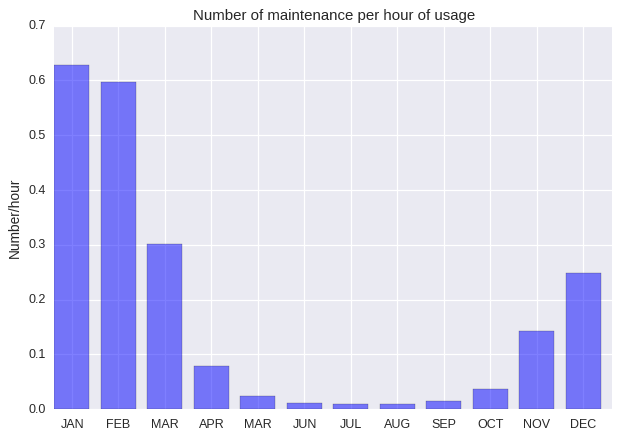

In [13]:
cutoff = 72.0
service_nums = []
usages = []
for month in range(12):
    service_nums.append(len(filter(lambda x: x>cutoff, gaptimes_by_month[month])))
    usages.append(trips_df[trips_df.startmonth==month+1].tripduration.sum()/3600.0)

index = np.arange(12)
bar_width = 0.75
plt.bar(index, np.array(service_nums)/np.array(usages), bar_width, color='b', alpha=0.5)
plt.title('Number of maintenance per hour of usage')
plt.ylabel('Number/hour')
plt.xticks(index+bar_width/2, ('JAN', 'FEB', 'MAR', 'APR', 'MAR', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'))
plt.show()

In [ ]:
bikeids = gaptimes_by_bikeid.keys()
trip_num = trips_df.groupby('bikeid')['tripduration'].count().values
trip_duration = trips_df.groupby('bikeid')['tripduration'].sum().values/3600.0  # in hour
service_num = np.array([len(gaptimes_by_bikeid[bikeid][gaptimes_by_bikeid[bikeid]>cutoff]) 
                        for bikeid in bikeids])
service_duration = np.array([gaptimes_by_bikeid[bikeid][gaptimes_by_bikeid[bikeid]>cutoff].sum() 
                             for bikeid in bikeids]) # in hour

bikes_df = pd.DataFrame({
        'bikeid': bikeids, 
        'trip_num': trip_num,  # number
        'trip_duration': trip_duration,  # hour
        'service_num': service_num,  # number
        'service_duration': service_duration,  # hour
        'norm_service_num': service_num/trip_duration,  # number per hour
        'norm_service_duration': service_duration/trip_duration,  # dimensionless
    }).set_index('bikeid')

In [ ]:
def func0(x, k, b):
    return np.multiply(k, x) + 0*b
popt0, pcov0 = curve_fit(func0, bikes_df.trip_duration.values, bikes_df.service_num)
xs0 = np.linspace(0, 380, 2)
plt.plot(xs0, func0(xs0, popt0[0], popt0[1]), 'r--')
plt.xlabel('Usage (hour)')
plt.ylabel('Number of maintenances')
plt.xlim(0, 380)
plt.ylim(0, 30)
plt.scatter(bikes_df.trip_duration.values, bikes_df.service_num, s=50, facecolors='None', edgecolors='b')

from scipy import stats
print 'Pearson correlation:', stats.pearsonr(bikes_df.trip_duration.values, bikes_df.service_num)[0]

In [ ]:
norm_service = {stationid: [0, 0] for stationid in stations_df.index}
for tripid, trip in trips_df[:250000].iterrows():
    norm_service[trip.from_station_id][0] += bikes_df.ix[trip.bikeid].norm_service_num
    norm_service[trip.from_station_id][1] += 1
    norm_service[trip.to_station_id][0] += bikes_df.ix[trip.bikeid].norm_service_num
    norm_service[trip.to_station_id][1] += 1
temp_array = np.array(norm_service.values())[:,0]/np.array(norm_service.values())[:,1]
stations_df['norm_service'] = temp_array
pickle.dump(stations_df, open('stations_2014.pickle', 'wb'))

In [ ]:
import cPickle as pickle
stations_df = pickle.load(open('stations_2014.pickle', 'rb'))
lons = stations_df.longitude
lats = stations_df.latitude
names = stations_df.name
services = stations_df.norm_service
min_num = stations_df.norm_service.min()
max_num = stations_df.norm_service.max()
colors = ["#%02x%02x%02x" % (255*(max_num-r)/(max_num-min_num), 
                             255*(max_num-r)/(max_num-min_num),
                             255)
          for r in stations_df.norm_service]

In [ ]:
#from __future__ import print_function
from bokeh.plotting import show, output_notebook
from bokeh.models.glyphs import Circle
from bokeh.models import (
    GMapPlot, GMapOptions, Range1d, ColumnDataSource,
    PanTool, WheelZoomTool, BoxZoomTool, BoxSelectTool, ResetTool, PreviewSaveTool, HoverTool)

output_notebook()

map_options = GMapOptions(lat=41.8827, lng=-87.6227, map_type="roadmap", zoom=12)

plot = GMapPlot(x_range=Range1d(), 
                y_range=Range1d(), 
                map_options=map_options, 
                title="Number of maintences per hour of usage")

plot.add_tools(PanTool(),
               WheelZoomTool(), 
               BoxZoomTool(),
               BoxSelectTool(),
               ResetTool(),
               PreviewSaveTool(),
               HoverTool())

source = ColumnDataSource(
    data = dict(
        x = lons,
        y = lats,
        radius = [12.5]*300,
        color = colors,
        name = names,
        service = services
    )
)

circle = Circle(x="x", y="y", size="radius", fill_color="color", line_color=None, fill_alpha=1)
plot.add_glyph(source, circle)

hover = plot.select(dict(type=HoverTool))
hover.point_policy = "follow_mouse"
hover.tooltips = OrderedDict([
    ("Station", "@name"),
    ("Maintenance", "@service times per hour of usage"),
])

show(plot)